In [10]:
from PIL import Image, ImageDraw
import math
import pandas as pd
import numpy as np

In [11]:
def drawBoundingRectangle(coordsTup , ImgObj, color='#ff0000', width=5, alpha=1.0):
    """
    Creates a box to highligt a location on the image object

    coordsTup = tuple of bbox corners. 
        top left coords = first 2 elements
        bottom right coords = last 2 elements
    width: width of outline
    color: hex value of color. Default red
    alpha: opacity. Range: 0,1
    """
    #Checking for transparency
    if alpha > 1 or alpha < 0: 
        alpha =1
    
    color_with_opacity = color + hex(int(alpha*255))[-2:]
    
    # Draw a rectangle
    draw = ImageDraw.Draw(ImgObj,'RGBA')
    
    p1_coord = coordsTup[0:2]
    p2_coord = coordsTup[2:4]
    draw.rectangle([p1_coord, p2_coord], outline=color_with_opacity, width=width)
    
    
def createNewPotentialBboxes(imgObj):
    img_width,  img_height = imgObj.size
    overlap = 0.7
    stride = 277*overlap 

    df_list = []
    for winsize in (277,277*2,277*3):
        if (winsize > img_width) or (winsize > img_height):
            break
        #if winsize odd, increase by 1 pixel. Just easier
        if (winsize % 2) != 0:
            winsize+=1
        xvals = np.arange((winsize/2), (img_width-winsize/2),stride)
        yvals = np.arange((winsize/2), (img_height-winsize/2),stride)
        list_centroids = [(x,y) for x in xvals for y in yvals]

        list_coordTuples = [get_bboxCoords(x_cnt,y_cnt,winsize) for x_cnt,y_cnt in list_centroids]

        #Appends new records for current winsize and bbox
        df_list.append(pd.DataFrame([list_coordTuples,[winsize]*len(list_coordTuples)]).T)

    df_bboxPotentials = pd.concat(df_list,ignore_index=True,axis=0)
    df_bboxPotentials.columns = ['bbox_bounds','winsize']
    df_bboxPotentials.to_csv(f'mass_maps/bboxPotentials_{img_width}_{img_height}.csv',index = False)
    return df_bboxPotentials

def get_bboxCoords(x_cnt,y_cnt,winsize):
    return int(x_cnt - winsize/2),int(y_cnt - winsize/2),int(x_cnt + winsize/2),int(y_cnt + winsize/2)

def getPotentialBboxes(imgObj,forceCreateNew = False):
    
    img_width,  img_height = imgObj.size
    
    if forceCreateNew:
        print('force creating new')
        df_bboxPotentials = createNewPotentialBboxes(imgObj)
    else:
        try:
            print('reading current')
            df_bboxPotentials = pd.read_csv(f'mass_maps/bboxPotentials_{img_width}_{img_height}.csv')
        except FileNotFoundError:
            print('no existing doc. creating')
            df_bboxPotentials = createNewPotentialBboxes(imgObj)
        
        
    return df_bboxPotentials

In [12]:
im1 = Image.open('mass_maps/ESP_068561_1700_RED.NOMAP.browse.jpg')
img_width,  img_height = im1.size
print(im1.size)

(2048, 2836)


In [127]:
getPotentialBboxes(im1,forceCreateNew=True)

force creating new


bbox_bounds winsize
0            (0, 0, 278, 278)     278
1          (0, 193, 278, 471)     278
2          (0, 387, 278, 665)     278
3          (0, 581, 278, 859)     278
4         (0, 775, 278, 1053)     278
..                        ...     ...
308  (1163, 1163, 1995, 1995)     832
309  (1163, 1357, 1995, 2189)     832
310  (1163, 1551, 1995, 2383)     832
311  (1163, 1745, 1995, 2577)     832
312  (1163, 1939, 1995, 2771)     832

[313 rows x 2 columns]

In [72]:
t=[(x,y) for x in xvals for y in yvals]
df = pd.DataFrame([t,[winsize]*len(t)]).T
df.columns = ['bbox_bounds','winsize']

In [73]:
df

bbox_bounds winsize
0    (416.0, 416.0)     832
1   (416.0, 1216.0)     832
2   (416.0, 2016.0)     832
3   (1216.0, 416.0)     832
4  (1216.0, 1216.0)     832
5  (1216.0, 2016.0)     832

In [58]:
pd.DataFrame(list_coordTuples)

0     1     2     3
0        0     0   831   831
1        0    45   831   876
2        0    90   831   921
3        0   135   831   966
4        0   180   831  1011
...    ...   ...   ...   ...
1255  1215  1800  2046  2631
1256  1215  1845  2046  2676
1257  1215  1890  2046  2721
1258  1215  1935  2046  2766
1259  1215  1980  2046  2811

[1260 rows x 4 columns]

In [45]:
mask_img = Image.new("RGBA", (img_width, img_height), (0, 0, 0, 0))
for tup in list_coordTuples:
    drawBoundingRectangle(tup,mask_img)

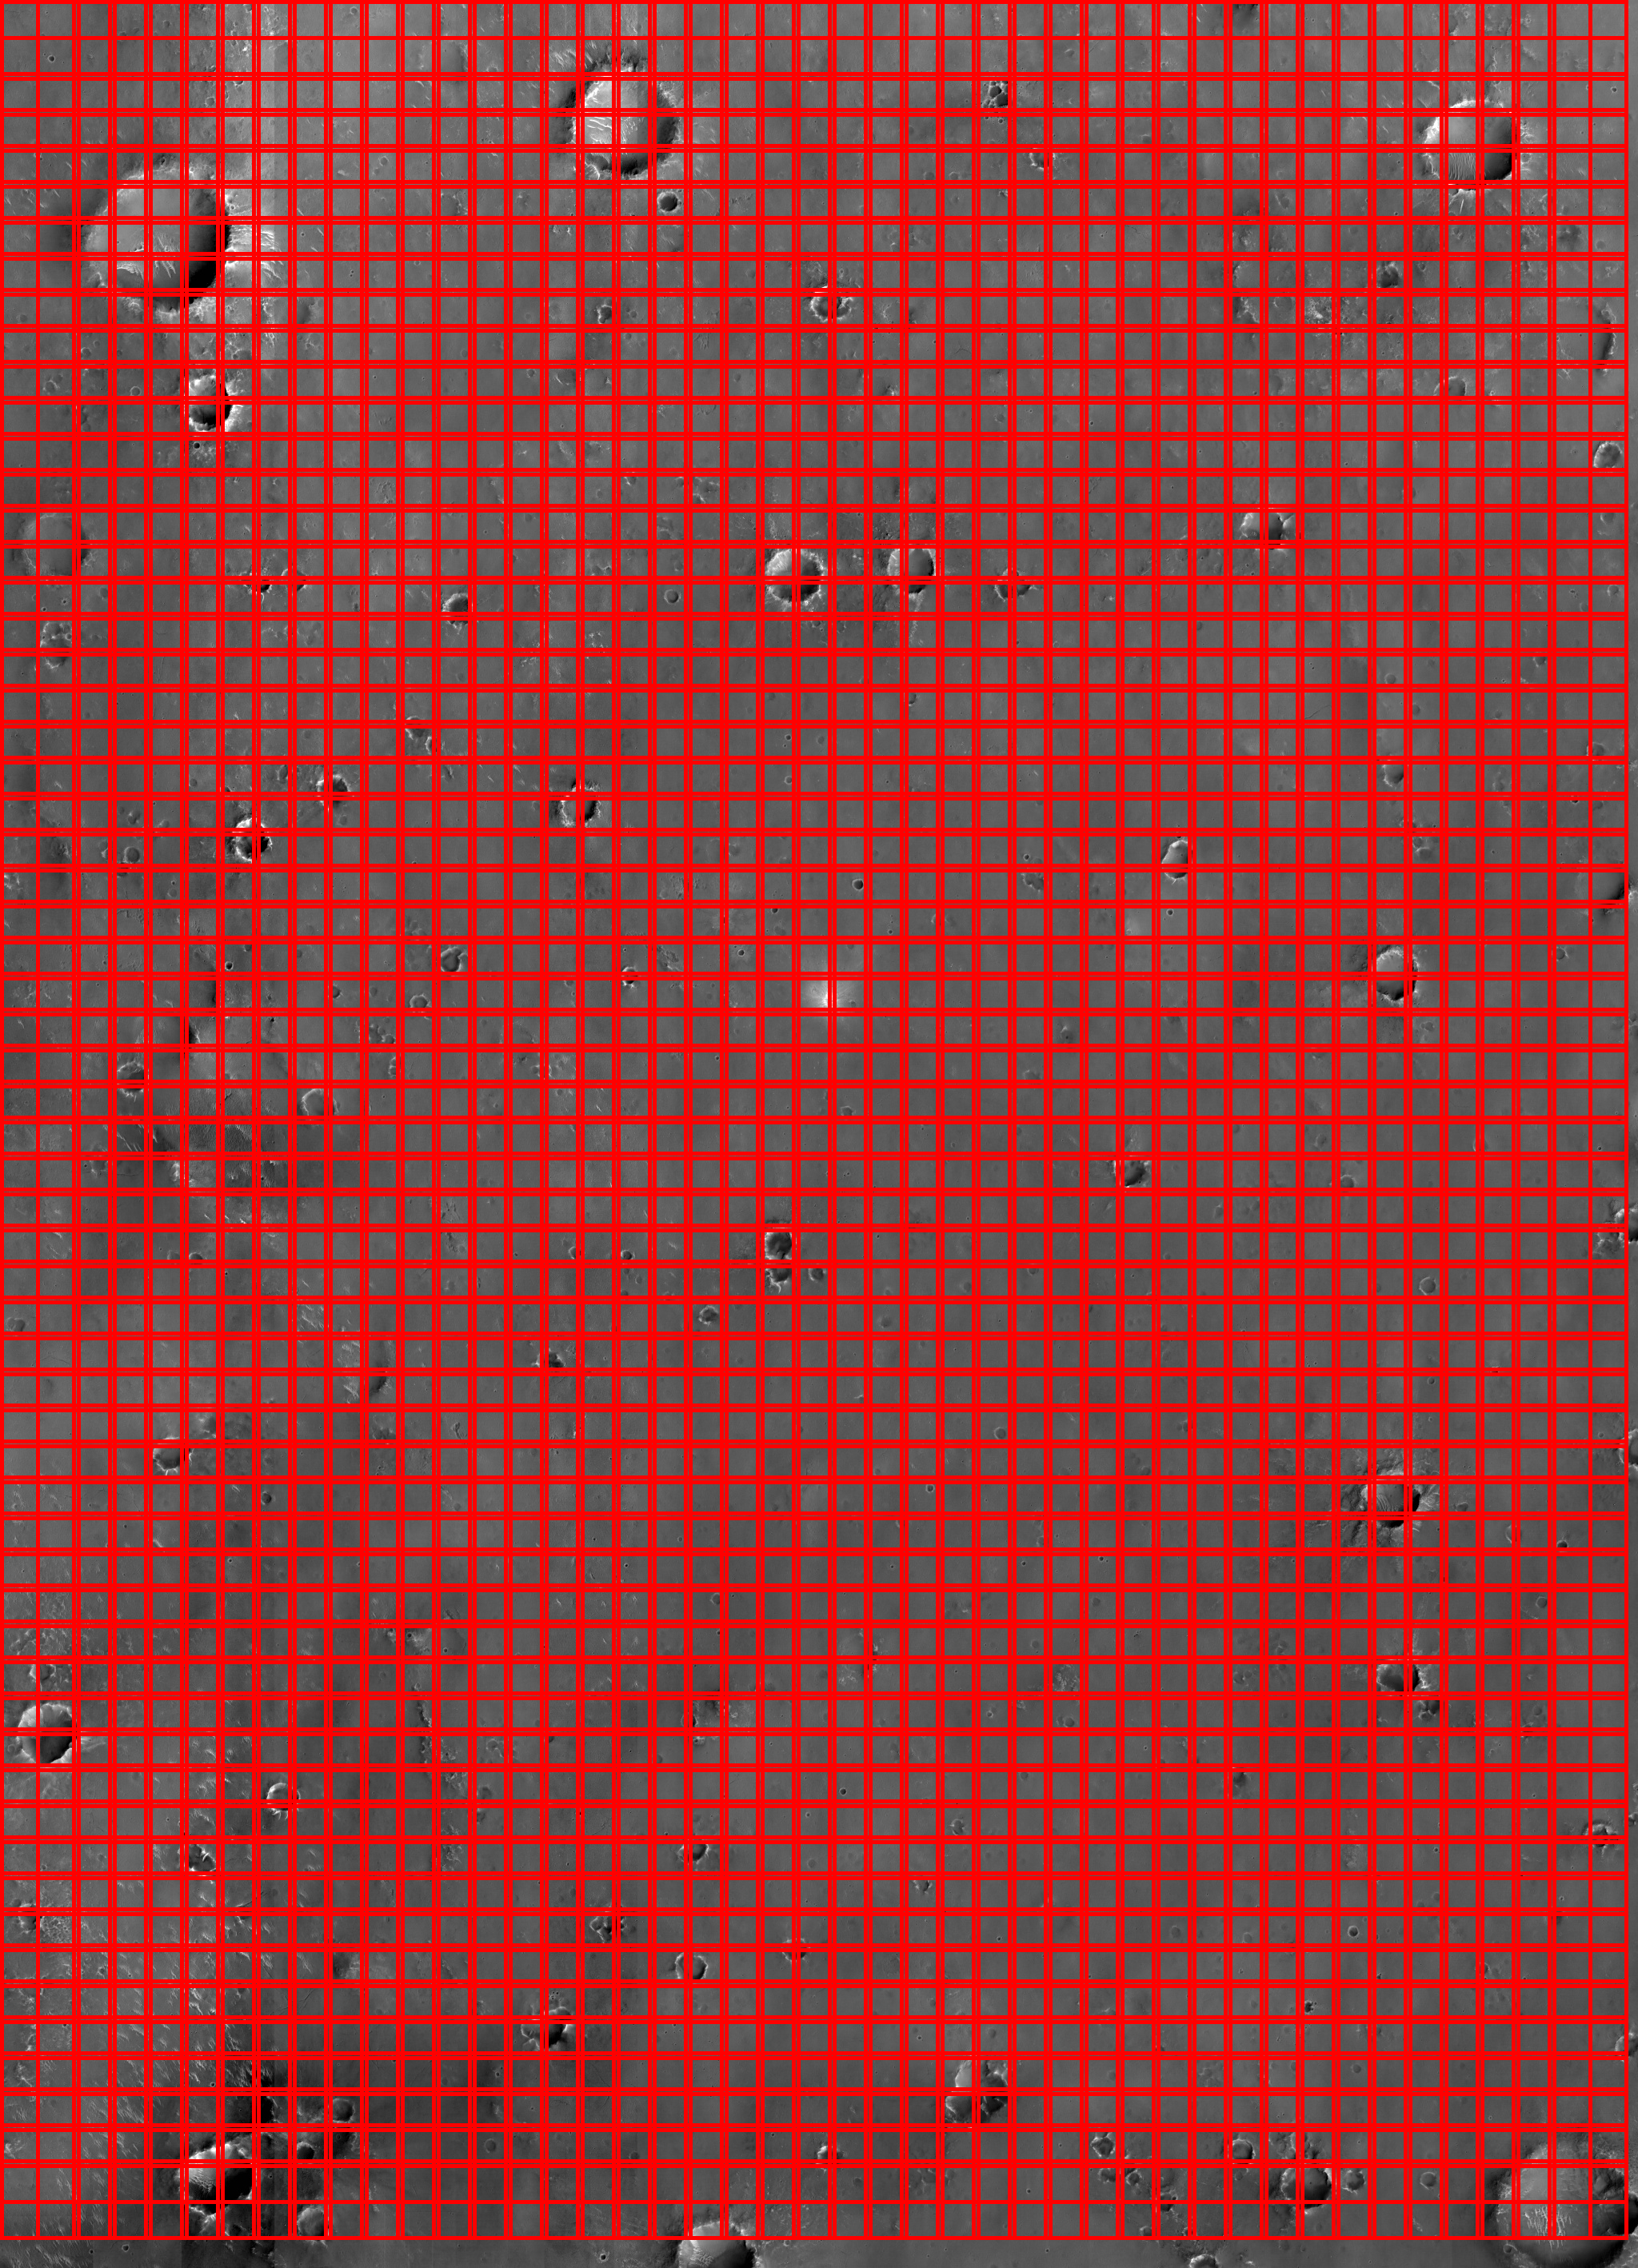

In [46]:
im2 = im1.convert('RGB')

im2.paste(mask_img,(0,0),mask_img)
im2